In [1]:
%store -r X

In [2]:
%store -r y

### Biblioteke

In [3]:
import torch
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

### Ucitavanje skupa

In [4]:
class OurDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.X)

In [5]:
dataset = OurDataset(X, y)

C:\Users\mihai\AppData\Local\Temp\ipykernel_125992\1720111584.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


In [6]:
dataset[0]

(tensor([ 0.2240,  0.2064,  0.2203,  0.2278,  0.2234,  0.2468,  0.2322,  0.2234,
          0.1647,  0.1098,  0.0618,  0.1230, -0.1513, -0.1194, -0.1181, -0.1640]),
 tensor(0.))

In [7]:
len(dataset)

110

In [8]:
dataset.y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

### Podela na train, val i test

In [9]:
#other_test_indices = list(range(43, 53)) + list(range(101, 108)) + list(range(156, 163))

In [10]:
other_test_indices = list(range(48, 55)) + list(range(103, 110))
dataset_indices = [x for x in range(len(dataset)) if x not in other_test_indices]
dataset_labels = [dataset.y[i] for i in dataset_indices]

#dataset_indices

In [11]:
random_state=42

In [12]:
whole_train_idx, test_idx = train_test_split(dataset_indices, test_size=30, stratify=dataset_labels, random_state=random_state)
test_dataset = Subset(dataset, test_idx)
len(test_dataset)

30

In [13]:
whole_train_dataset = Subset(dataset, whole_train_idx)
wtd_labels = [dataset.y[i] for i in whole_train_idx]
#print(wtd_labels)
train_idx, val_idx = train_test_split(whole_train_idx, test_size=15, stratify=wtd_labels, random_state=random_state)
val_dataset = Subset(dataset, val_idx)
len(val_dataset)

15

In [14]:
train_dataset = Subset(dataset, train_idx)
len(train_dataset)

51

In [15]:
other_test_dataset = Subset(dataset, other_test_indices)
len(other_test_dataset)

14

### Pravljenje dataloader-a

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)
other_test_loader = DataLoader(other_test_dataset, batch_size=4)

### Konstrukcija neuronske mreze

In [17]:
num_attr = len(dataset.X[0])
num_attr

16

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(num_attr, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 1)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        return x.squeeze(1)

In [19]:
model = Net()
device = 'gpu' if torch.cuda.is_available() else 'cpu'
model.to(device)
model

Net(
  (layer1): Linear(in_features=16, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=1, bias=True)
  (activation): ReLU()
)

In [20]:
loss_fn = CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [21]:
optimizer = Adam(model.parameters(), lr=0.001)
optimizer

C:\Users\mihai\anaconda3\envs\gpu_env\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

### Treniranje modela

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    
    total_loss = 0
    num_same = 0
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        #forward pass
        outputs = model(X)
        loss = loss_fn(outputs, y)
        total_loss += loss.item()
        
        if len(outputs.shape) == 1: # accuracy - dve klase
            preds = outputs > 0
            num_same += sum(preds == y).item()
                
        else: # accuracy - vise klasa
            _, indices = torch.max(outputs, 1)
            num_same += sum(indices == y).item()
        
        #backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    avg_loss = total_loss / len(dataloader.dataset)
    acc = num_same / len(dataloader.dataset)
    return avg_loss, acc

### Testiranje modela

In [23]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            if len(outputs.shape) == 1: # accuracy - dve klase
                preds = outputs > 0
                #print(outputs)
                print(preds, " : ", y)
                num_same += sum(preds == y).item()
                
            else: # accuracy - vise klasa
                _, indices = torch.max(outputs, 1)
                #print(outputs)
                print(indices, " : ", y)
                num_same += sum(indices == y).item()
        
        avg_loss = total_loss / len(dataloader.dataset)
        acc = num_same / len(dataloader.dataset)
        print(f'Average loss: {avg_loss}')
        print(f'Accuracy: {acc}')
        print()
        
        return avg_loss, acc

### Main code

In [24]:
num_epochs = 200

train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_val_acc = float('-inf')
last_val_acc = float('-inf')
best_model_weights = model.state_dict()
best_epoch = -1

for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc = test_loop(val_loader, model, loss_fn, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_acc > best_val_acc and val_acc == last_val_acc:
        #print(val_acc)
        best_val_acc = val_acc
        best_model_weights = model.state_dict()
        torch.save(best_model_weights, './models/best_model.pth')
        best_epoch = epoch
    
    last_val_acc = val_acc
    
print(val_acc, ' : ', best_val_acc)
if best_val_acc < val_acc:
    best_epoch = epoch
    torch.save(model.state_dict(), './models/best_model.pth')

  2%|█▏                                                                                | 3/200 [00:00<00:09, 21.11it/s]

tensor([True, True, True, True])  :  tensor([0., 1., 0., 0.])
tensor([True, True, True, True])  :  tensor([0., 1., 1., 0.])
tensor([True, True, True, True])  :  tensor([1., 1., 0., 1.])
tensor([True, True, True])  :  tensor([0., 1., 0.])
Average loss: 0.6196665684382121
Accuracy: 0.4666666666666667

tensor([True, True, True, True])  :  tensor([0., 1., 0., 0.])
tensor([True, True, True, True])  :  tensor([0., 1., 1., 0.])
tensor([True, True, True, True])  :  tensor([1., 1., 0., 1.])
tensor([True, True, True])  :  tensor([0., 1., 0.])
Average loss: 0.6062543392181396
Accuracy: 0.4666666666666667

tensor([False,  True, False,  True])  :  tensor([0., 1., 0., 0.])
tensor([True, True, True, True])  :  tensor([0., 1., 1., 0.])
tensor([True, True, True, True])  :  tensor([1., 1., 0., 1.])
tensor([True, True, True])  :  tensor([0., 1., 0.])
Average loss: 0.5823466579119364
Accuracy: 0.6

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  t

  4%|███▋                                                                              | 9/200 [00:00<00:07, 25.81it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3989235003789266
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3541554977496465
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3335590933760007
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, Fa

  8%|██████▍                                                                          | 16/200 [00:00<00:06, 28.74it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.32138334748645625
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.32009506759544215
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3198050948480765
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, 

 12%|█████████▎                                                                       | 23/200 [00:00<00:06, 29.43it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31686760721107327
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31643275084594885
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31600225729246934
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True,

 13%|██████████▌                                                                      | 26/200 [00:00<00:06, 28.60it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3152182094597568
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3148532345425338
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3146181845416625
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, Fa

 17%|█████████████▊                                                                   | 34/200 [00:01<00:05, 29.64it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3140611642583584
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3139239754372587
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3136994681398695
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, Fa

 21%|█████████████████                                                                | 42/200 [00:01<00:05, 30.31it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3132152296913167
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31305926808466517
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3129467925444866
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, F

 23%|██████████████████▋                                                              | 46/200 [00:01<00:04, 31.62it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3126353555067908
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31261957389457773
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31258210421268207
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, 

 27%|█████████████████████▊                                                           | 54/200 [00:01<00:04, 30.38it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3125032728518515
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3125672653540581
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3125013081211364
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, Fa

 31%|█████████████████████████                                                        | 62/200 [00:02<00:04, 31.62it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31239318691077644
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31240292785611623
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3123846622135413
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, 

 33%|██████████████████████████▋                                                      | 66/200 [00:02<00:04, 30.53it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3123397756038078
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31233587421593256
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31233745573238897
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, 

 37%|█████████████████████████████▉                                                   | 74/200 [00:02<00:04, 29.70it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3123298664572455
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3123142837771108
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31231021457315367
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, F

 40%|████████████████████████████████▍                                                | 80/200 [00:02<00:04, 29.02it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31227621018685264
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3122910620767167
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31227015407979103
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, 

 44%|███████████████████████████████████▏                                             | 87/200 [00:02<00:03, 29.89it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3122396060687606
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3122379531348391
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31223504445855116
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, F

 45%|████████████████████████████████████▍                                            | 90/200 [00:03<00:03, 29.56it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31223529081356294
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31222977533980156
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3122170995899675
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, 

 50%|████████████████████████████████████████                                        | 100/200 [00:03<00:03, 29.36it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121990755639975
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121976689061133
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121972794414736
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, Fa

 52%|█████████████████████████████████████████▌                                      | 104/200 [00:03<00:03, 30.02it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121845718846392
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31218113871303405
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31217939035974873
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, 

 56%|████████████████████████████████████████████▊                                   | 112/200 [00:03<00:02, 30.35it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121751306539712
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121740259875575
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121715782414564
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, Fa

 60%|████████████████████████████████████████████████                                | 120/200 [00:04<00:02, 30.72it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121657767621097
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31216497410324945
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31216435420936556
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, 

 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:04<00:02, 30.52it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215898187761015
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121578533758717
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31216218456074785
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, 

 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:04<00:02, 30.38it/s]

tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31216063491115165
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215851299845476
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121570586516858
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False, 

 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:04<00:02, 30.77it/s]

tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121524889875218
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121526002512231
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121523379893309
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor

 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [00:04<00:01, 31.59it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121539433521548
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215422945469223
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215329961725424
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, 

 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:05<00:01, 31.13it/s]

Average loss: 0.3121528386862034
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121517578553115
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215163070031243
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.312150788288371
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([

 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [00:05<00:01, 31.31it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121507803425402
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215113797259925
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215143997044
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, Fal

 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [00:05<00:01, 31.35it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215164660036027
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215132076248436
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.312149866410122
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, F

 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [00:05<00:01, 31.47it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215026377660704
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31214933394499744
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121485153739362
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, 

 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [00:05<00:00, 28.91it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121491749990355
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31214976309868236
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121522267583032
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, F

 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [00:06<00:00, 30.77it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121520678131939
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121504386203583
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121498107852517
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, Fa

 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [00:06<00:00, 30.02it/s]

tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215663749910616
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121602694106135
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.312157924962105
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  T

 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [00:06<00:00, 30.28it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121501684146987
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.3121509949326821
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215036709739363
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, F

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 30.01it/s]

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.312148801482482
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31215029557266877
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, False])  :  tensor([0., 1., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([False,  True, False])  :  tensor([0., 1., 0.])
Average loss: 0.31214899221801223
Accuracy: 1.0

tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([False,  True,  True, F

In [25]:
print(best_epoch)

4


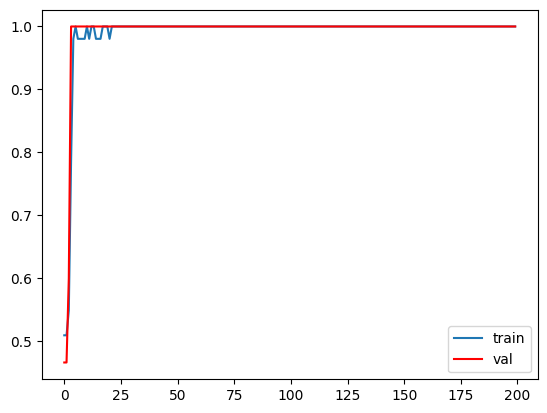

In [26]:
plt.plot(range(num_epochs), train_accs, label='train')
plt.plot(range(num_epochs), val_accs, color='red', label='val')
plt.legend()

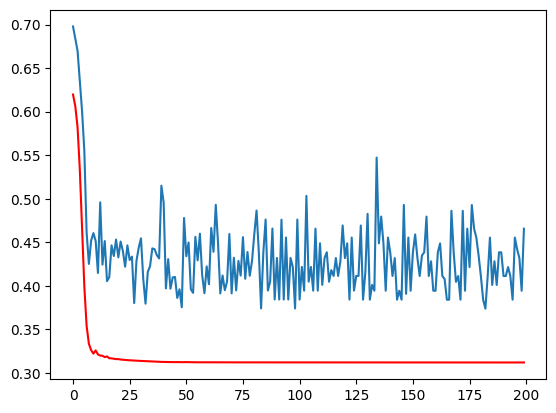

In [27]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), val_losses, color='red')

In [28]:
model.load_state_dict(torch.load('./models/best_model.pth'))

<All keys matched successfully>

In [29]:
test_loss, test_acc = test_loop(test_loader, model, loss_fn, device)

tensor([False, False,  True,  True])  :  tensor([0., 0., 1., 1.])
tensor([False,  True, False, False])  :  tensor([0., 1., 0., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([ True, False,  True,  True])  :  tensor([1., 0., 1., 1.])
tensor([False, False, False,  True])  :  tensor([0., 0., 0., 1.])
tensor([False, False,  True,  True])  :  tensor([0., 0., 1., 0.])
tensor([ True,  True, False,  True])  :  tensor([1., 1., 0., 1.])
tensor([ True, False])  :  tensor([1., 0.])
Average loss: 0.5299187918504079
Accuracy: 0.9666666666666667



In [30]:
print(val_idx)

[29, 70, 43, 45, 17, 65, 93, 27, 75, 57, 0, 95, 13, 77, 5]


In [31]:
print(test_idx)

[38, 28, 71, 98, 20, 56, 23, 36, 58, 74, 41, 90, 82, 18, 79, 62, 35, 47, 14, 89, 2, 22, 61, 7, 101, 80, 42, 68, 63, 10]


In [32]:
other_test_loss, other_test_acc = test_loop(other_test_loader, model, loss_fn, device)

tensor([False, False, False, False])  :  tensor([0., 0., 0., 0.])
tensor([False, False, False,  True])  :  tensor([0., 0., 0., 1.])
tensor([True, True, True, True])  :  tensor([1., 1., 1., 1.])
tensor([True, True])  :  tensor([1., 1.])
Average loss: 0.545828810759953
Accuracy: 1.0



In [33]:
other_test_indices

[48, 49, 50, 51, 52, 53, 54, 103, 104, 105, 106, 107, 108, 109]